In [1]:
import pandas as pd
import numpy as np
import math
import scipy
import os
import ivolatility as ivol
from scipy.stats import norm
pd.options.mode.chained_assignment = None

## **Trade Analysis of the Bullish Risk Reversal Option Strategy on 2025-04-09**

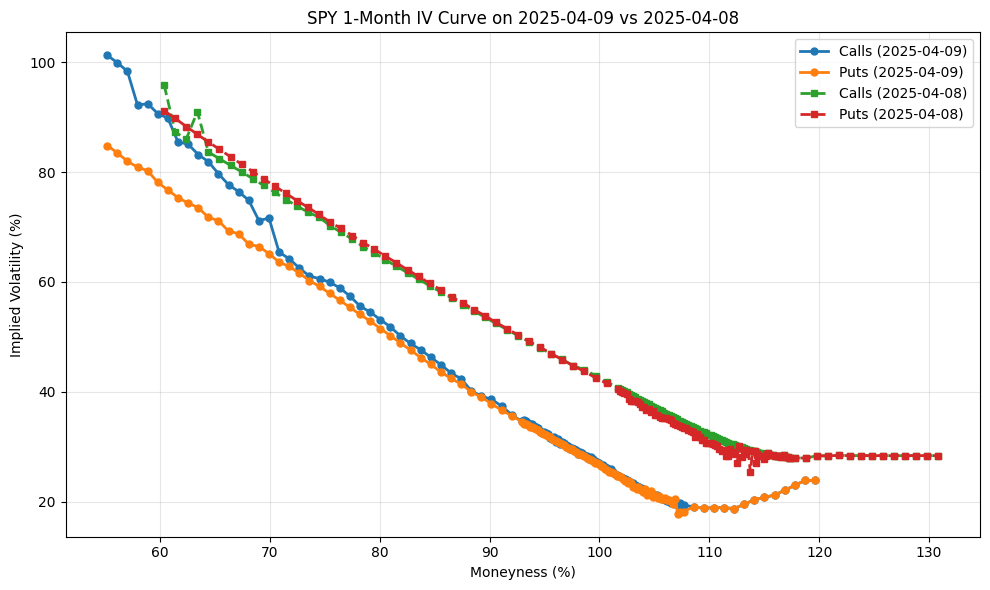

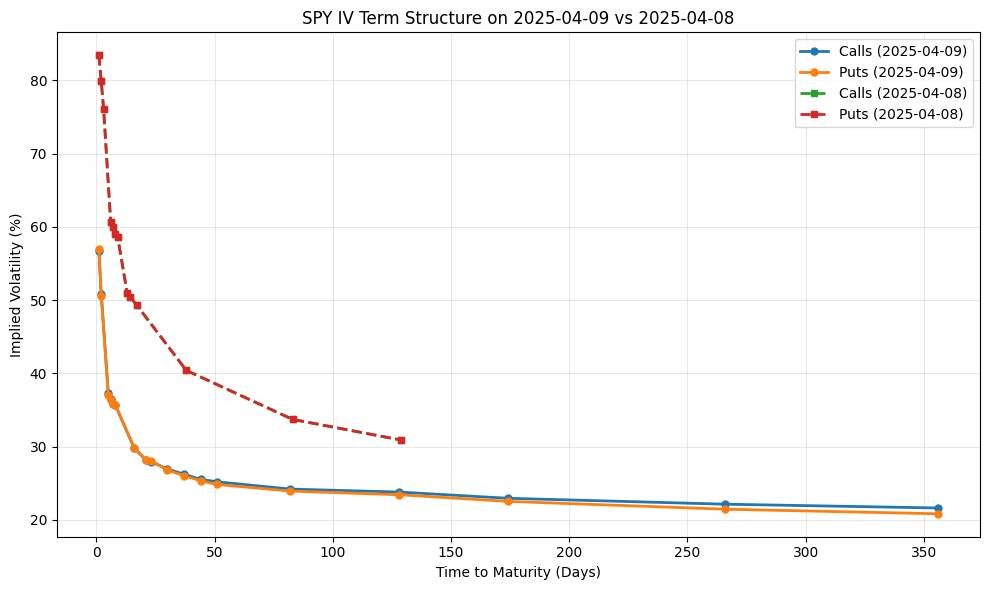

* Market rally context: On 9 April 2025, the announced 90-day pause on most of Donald Trump’s newly announced reciprocal tariffs triggered a sharp relief rally. The S&P 500 jumped about +10% while the Nasdaq Composite rose over +12 %. At the same time implied volatilities across the moneyness and tenure spectrum collapsed (both skew and term structure compressed) as uncertainty eased and the market registered a strong directional move. The drop in IV meant option premiums fell for given strikes, both puts and calls became cheaper which impacts the pricing of structures: long options lose value from the “vol crush”, while short-premium sellers (especially puts) benefit if IV contraction is baked in.

* If the market will continue higher (momentum) and vol will stay suppressed, then buying OTM calls + selling OTM puts (Bullish Risk Reversal) at the late afternoon may feel like a strong move.

### Specific Decision (Personal view)

Given all of the above, I would **not** enter the trade late in the afternoon of 4/9/2025.

> The trade is being proposed *after* the bulk of the rally triggered by the tariff pause news. The market has already run, implied vol has already compressed, and much of the favourable move may be behind us. Entering a short‐put/long‐call structure at this juncture leaves us vulnerable to a reversal or simply a drift sideways where theta and vega hurt the position, while the upside is limited because much of the move has happened. Meanwhile the downside remains large and asymmetric. Unless one has a strong conviction that SPY will rally further (e.g., ~ +5% - +10% more) in the next month and the IV skews flattening, the risk‐reward is unfavourable from my point of view. If anything, I might prefer a more conservative bullish structure (e.g., a call spread or selling a narrower put spread) rather than having a naked large‐volume short puts in the risk reversal strategy.

## **Backtesting of Trade Structure**

In [2]:
df_hisotrical_spy_return_summary= pd.read_csv('../data/SPY/SPY_daily_return_summary_statistic.csv')
df_hisotrical_spy_return_summary

,Total Trading Days,mean,std,median,skewness,kurtosis,min,max,jb_stat,jb_pvalue,return_value,z_score,percentile_rank,percentile_1,percentile_5,percentile_25,percentile_50,percentile_75,percentile_95,percentile_99
0,6355,0.000356,0.012302,0.000669,0.052612,12.000972,-0.109424,0.145197,38073.138416,0.0,0.105019,8.50814,99.968529,-0.034287,-0.019204,-0.004695,0.000669,0.005996,0.017305,0.03353


In [3]:
df_spy_return= pd.read_csv('../data/SPY/SPY_return_processed.csv')
df_spy_return.rename(columns={'Price': 'Date'}, inplace=True)
df_spy_return = df_spy_return.iloc[2:]
df_spy_return['Date'] = pd.to_datetime(df_spy_return['Date'], format='%m/%d/%y')

df_spy_rally_return = df_spy_return[df_spy_return['Daily_Return']>=0.07]

df_spy_rally_return

,Date,Adj Close,Close,High,Low,Open,Volume,Daily_Return,Cumulative_Return,Rolling_17d_Return
2209,2008-10-13,73.93862152,101.3499985,101.3499985,89.94999695,93.87000275,455584000,0.145197,-0.195338,-0.151023
2220,2008-10-28,68.40144348,93.76000214,94.23999786,84.52999878,87.33999634,639939500,0.116855,-0.255598,-0.150263
2319,2009-03-23,60.90232086,82.22000122,82.29000092,78.30999756,78.73999786,419933300,0.071829,-0.337210,0.095060
5082,2020-03-13,247.5242462,269.3200073,271.480011,248.5200043,263.0899963,329566100,0.085486,1.693767,-0.203996
5089,2020-03-24,224.7861938,243.1499939,244.1000061,233.8000031,234.4199982,235494500,0.090603,1.446312,-0.174442
6357,2025-04-09,545.4906006,548.6199951,548.6199951,493.0499878,493.4400024,241867300,0.105019,4.936486,-0.029762


To evaluate whether this trade structure is historically justified, I will backtest it using SPY data from 2000 onward, focusing specifically on extreme upside shock regimes that resemble April 9 2025. Because April 9 registered the third-largest single-day gain in SPY in the past 25 years (out of more than 6,300 trading days), it represents an extremely rare volatility collapse and sentiment shift environment. For context, the **99th percentile of SPY daily returns is only about +3.35%**, corresponding to roughly 64 outlier days since 2000. Therefore, the April 9 event lies far beyond typical tail behavior. 

> To build an analogue set that better matches this extremity, I will focus on the handful of **days with returns above +7%**, approximately six such trading days since 2000—to more accurately reflect the post-shock environment relevant to this trade. I will then examine how SPY performed over the following 3 weeks (~17 trading days) and how implied volatility evolved on the OTM options. This regime-based backtest will allow me to assess how often large upward shocks lead to continued follow-through (supporting the long-call side of the structure) versus mean-reversion or drawdowns (highlighting the risks of the short-put leg). It will also capture how IV typically behaves after such rallies, usually sharp vol-crush followed by muted or drifting IV—which directly affects the PnL of the structure. We can see from the historical instances that extreme positive daily returns in SPY almost always occur during deep bear-market stress, such as the 2008 financial crisis and the 2020 COVID crash.

In [4]:
def backtest_trade_pnl(
    n_put_contracts: int,
    V_p_0: float,
    V_p_t: float,
    V_c_0: float,
    V_c_t: float,
    risk_free_rate: float,     # r
    rf_compounding_period: float    # t in years
) -> tuple:
    """
    Compute the PNL of the risk reversal,

    Formula used:
        PNL_t =
            + n_put_contracts  * 100 * (V_p_0 - V_p_t)
            + n_call_contracts * 100 * (V_c_t - V_c_0)
            + net_premium * (e^(r*t) - 1)

    Where:
        n_put_contracts  : number of short put option contracts
        n_call_contracts : number of long call option contracts
        V_p_0, V_p_t     : initial and final put prices
        V_c_0, V_c_t     : initial and final call prices
        net_premium      : net premium (cash flow at t=0)
        risk_free_rate   : r
        rf_compounding_period : t in years

    Returns: pnl_total : Total Pnl of the strategy
    """
    premium_collected = n_put_contracts * 100 * V_p_0
    n_call_contracts = int(premium_collected // (V_c_0 * 100))
    net_premium = premium_collected - n_call_contracts * 100 * V_c_0
    
    # --- PNL from short puts ---
    term_put = n_put_contracts * 100 * (V_p_0 - V_p_t)

    # --- PNL from long calls ---
    term_call = n_call_contracts * 100 * (V_c_t - V_c_0)

    # --- Carry on cash premium ---
    term_carry = net_premium * (math.exp(risk_free_rate * rf_compounding_period) - 1)

    pnl_total = term_put + term_call + term_carry

    pnl_perecntage = pnl_total / premium_collected

    return pnl_total, pnl_perecntage

In [5]:
rally_dates = list(df_spy_rally_return['Date'])
rally_dates

[Timestamp('2008-10-13 00:00:00'),
 Timestamp('2008-10-28 00:00:00'),
 Timestamp('2009-03-23 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2025-04-09 00:00:00')]

In [6]:
df_hist_rf = pd.read_csv('../data/Yield/historical_yield.csv')
df_hist_rf = df_hist_rf.ffill()
df_hist_rf

,observation_date,DGS1MO
0,2001-07-31,3.67
1,2001-08-01,3.65
2,2001-08-02,3.65
3,2001-08-03,3.63
4,2001-08-06,3.62
...,...,...
6334,2025-11-10,4.04
6335,2025-11-11,4.04
6336,2025-11-12,4.03
6337,2025-11-13,4.05


In [7]:
df_options_on_rally = pd.read_csv('../data/Option/historical_options_prices_on_and_after_rally_days.csv')
df_options_on_rally

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement,absolute_change
0,2008-10-13,SWGWR,40,627,2008-11-22,P,96.0,8.05,8.40,4.35,...,-0.079974,0.120172,-0.036274,4.50,4.35,101.35,5.28,NaN,0,5.6
1,2008-10-13,SWGKB,40,627,2008-11-22,C,106.0,2.70,4.00,2.21,...,-0.080062,0.129650,0.041189,4.35,4.15,101.35,4.59,NaN,0,8.2
2,2008-11-05,SWGWR,17,627,2008-11-22,P,96.0,2.60,4.41,2.23,...,-0.117984,0.082559,-0.020001,4.00,3.90,96.19,0.20,NaN,0,NaN
3,2008-11-05,SWGKB,17,627,2008-11-22,C,106.0,1.04,1.14,0.47,...,-0.052859,0.045356,0.005852,0.55,0.53,96.19,10.20,NaN,0,NaN
4,2008-10-28,SZCWK,25,627,2008-11-22,P,89.0,6.75,8.55,3.90,...,-0.115260,0.089995,-0.022160,4.15,3.95,93.76,5.08,NaN,0,1.6
5,2008-10-28,SWGKT,25,627,2008-11-22,C,98.0,1.85,3.85,1.35,...,-0.108802,0.095686,0.024054,3.85,3.65,93.76,4.52,NaN,0,9.6
6,2008-11-20,SZCWK,2,627,2008-11-22,P,89.0,8.90,13.75,6.74,...,-0.119975,0.001647,-0.001327,13.90,13.25,75.45,-17.96,NaN,0,NaN
7,2008-11-20,SWGKT,2,627,2008-11-22,C,98.0,0.01,0.03,0.01,...,-0.009023,0.000115,0.000002,0.02,0.01,75.45,29.89,NaN,0,NaN
8,2009-03-23,SZCPZ,26,627,2009-04-18,P,78.0,3.00,3.10,1.80,...,-0.065305,0.075398,-0.016752,1.94,1.89,82.22,5.13,NaN,0,2.6
9,2009-03-23,SZCDH,26,627,2009-04-18,C,86.0,0.74,1.72,0.62,...,-0.057741,0.078621,0.017863,1.69,1.65,82.22,4.60,NaN,0,8.0


In [8]:
# ------------------------------------------------------------
# Historical Backtest after Huge Rally Days:
#   - df_options_on_rally: options data around big SPY rallies
#   - For each rally, we take a 4-row block:
#       * first 2 rows  = "early" (rally date)
#       * next  2 rows  = "later" (17 trading days after)
#
#   Within each block, we assume:
#       - exactly 1 Call and 1 Put in the first 2 rows
#       - exactly 1 Call and 1 Put in the last  2 rows
#
#   We then:
#       1. Extract S_0, S_t (SPY spot at early and later dates)
#       2. Extract option prices & IVs for Put and Call at both dates
#       3. Pull risk-free rate on the initial date
#       4. Compute PnL of the trade via backtest_trade_pnl()
#       5. Store all metrics row-by-row into result_df
# ------------------------------------------------------------

results = []

n = len(df_options_on_rally)

# Iterate over df_options_on_rally in 4-row chunks
for i in range(0, n, 4):
    # 4-row block: [early_call, early_put, later_call, later_put]
    block = df_options_on_rally.iloc[i:i+4]

    # Safety check (optional): skip incomplete blocks
    if len(block) < 4:
        continue

    # -----------------------
    # 1) Early (rally) snapshot
    # -----------------------
    early = block.iloc[0:2]       # first 2 rows
    initial_date = early['c_date'].iloc[0]

    # Rally return on the initial date
    rally_return = df_spy_rally_return.loc[
        df_spy_rally_return['Date'] == initial_date,
        'Daily_Return'
    ].values[0]

    # SPY spot at rally date
    S_0 = float(
        df_spy_return.loc[
            df_spy_return['Date'] == initial_date,
            'Adj Close'
        ].values[0]
    )

    # Option prices & IVs at rally date
    V_c_0 = early.loc[early['call_put'] == 'C', 'price'].values[0]
    call_iv_0 = early.loc[early['call_put'] == 'C', 'iv'].values[0]

    V_p_0 = early.loc[early['call_put'] == 'P', 'price'].values[0]
    put_iv_0 = early.loc[early['call_put'] == 'P', 'iv'].values[0]

    # -----------------------
    # 2) Later snapshot (17 trading days after rally)
    # -----------------------
    later = block.iloc[2:4]       # next 2 rows
    later_date = later['c_date'].iloc[0]

    # SPY spot at later date
    S_t = float(
        df_spy_return.loc[
            df_spy_return['Date'] == later_date,
            'Adj Close'
        ].values[0]
    )

    # Option prices & IVs at later date
    V_c_t = later.loc[later['call_put'] == 'C', 'price'].values[0]
    call_iv_t = later.loc[later['call_put'] == 'C', 'iv'].values[0]

    V_p_t = later.loc[later['call_put'] == 'P', 'price'].values[0]
    put_iv_t = later.loc[later['call_put'] == 'P', 'iv'].values[0]

    # -----------------------
    # 3) Risk-free rate on rally date
    # -----------------------
    rf_series = df_hist_rf.loc[
        df_hist_rf['observation_date'] == initial_date,
        'DGS1MO'
    ]
    risk_free_rate = rf_series.iloc[0]

    # -----------------------
    # 4) PnL of the trade
    # -----------------------
    # backtest_trade_pnl(
    #   num_puts, V_p_0, V_p_t, V_c_0, V_c_t,
    #   risk_free_rate, rf_compounding_period
    # )
    pnl, pnl_percentage = backtest_trade_pnl(
        1000,                 # Number of put options (position size)
        V_p_0,                # Initial put price
        V_p_t,                # Later  put price
        V_c_0,                # Initial call price
        V_c_t,                # Later  call price
        risk_free_rate=risk_free_rate,
        rf_compounding_period=21 / 365  # ~21 trading days
    )

    # -----------------------
    # 5) Save all metrics
    # -----------------------
    results.append({
        'date_rally': initial_date,
        'rally_return(%)': rally_return * 100,

        'date_17_trading_days_after_rally': later_date,

        # Initial snapshot (Put first, then Call)
        'S_0': S_0,
        'V_p_0': V_p_0,
        'V_c_0': V_c_0,
        'put_iv_0': put_iv_0,
        'call_iv_0': call_iv_0,

        # Later snapshot (Put first, then Call)
        'S_t': S_t,
        'V_p_t': V_p_t,
        'V_c_t': V_c_t,
        'put_iv_t': put_iv_t,
        'call_iv_t': call_iv_t,

        # Changes in spot and IVs
        'change_in_spot_price(%)': round(100 * (S_t - S_0) / S_0, 2),
        'change_in_put_iv(%)': round(100 * (put_iv_t - put_iv_0) / put_iv_0, 2),
        'change_in_call_iv(%)': round(100 * (call_iv_t - call_iv_0) / call_iv_0, 2),

        # PnL (absolute and %)
        'pnl_dollars': round(pnl, 2),
        'pnl_percentage(%)': round(pnl_percentage * 100, 2),
    })

# ------------------------------------------------------------
# Convert the results list into a DataFrame and save to CSV
# ------------------------------------------------------------
result_df = pd.DataFrame(results)
result_df = result_df.set_index('date_rally')

result_df.to_csv('../data/Result/2_Historical_Backtest_Result.csv')

result_df


,rally_return(%),date_17_trading_days_after_rally,S_0,V_p_0,V_c_0,put_iv_0,call_iv_0,S_t,V_p_t,V_c_t,put_iv_t,call_iv_t,change_in_spot_price(%),change_in_put_iv(%),change_in_call_iv(%),pnl_dollars,pnl_percentage(%)
date_rally,,,,,,,,,,,,,,,,,
2008-10-13,14.519722,2008-11-05,73.938622,4.425000,4.25,0.540762,0.452216,70.174240,3.950,0.540,0.493606,0.391128,-5.09,-8.72,-13.51,-338710.70,-76.54
2008-10-28,11.685516,2008-11-20,68.401443,4.050000,3.75,0.651912,0.553094,55.043610,13.575,0.015,1.470264,1.571525,-19.53,125.53,184.13,-1355880.00,-334.79
2009-03-23,7.182907,2009-04-15,60.902321,1.915000,1.67,0.436584,0.364805,63.146709,0.035,0.765,0.592196,0.434524,3.69,35.64,19.11,84287.67,44.01
2020-03-13,8.548621,2020-04-07,247.524246,12.219999,7.46,0.570852,0.430485,245.106232,3.175,0.360,0.464445,0.366145,-0.98,-18.64,-14.95,-258479.13,-21.15
2020-03-24,9.060298,2020-04-16,224.786194,10.635000,9.63,0.590034,0.514218,258.021088,0.165,24.115,0.617138,0.493970,14.79,4.59,-3.94,2646144.20,248.81


>We can see from historical instances that extreme positive daily returns in SPY almost always occur during periods of deep bear-market stress, such as the 2008 financial crisis and the 2020 COVID crash. In these environments, it is difficult to determine whether the market will continue to rally, move sideways, or reverse based solely on price data. In the following 3 weeks, SPY can continue to rally (as it did with a +14.79% gain on 2020-03-24) or decline sharply (as seen with a -19.53% drop on 2008-10-28).

>Without referencing the economic conditions at those points in time or the underlying reasons that caused the rallies, it is challenging to assess whether a bullish trend will continue, information that would be crucial for the strategy. Therefore, without looking forward to SPY’s performance after April 9, my view is that despite the sharp relief rally triggered by the tariff-pause announcement, the unresolved trade-war risks—particularly the elevated tariffs on China and signs of stress in the bond market suggest that this move is more likely a short-term rebound rather than a sustained trend.
